In [1]:
import os
import torch
import cv2
import cPickle
import numpy as np
import errno

from faster_rcnn import network
from faster_rcnn.faster_rcnn_x import FasterRCNN, FasterRCNN_x
from faster_rcnn.utils.timer import Timer
from faster_rcnn.fast_rcnn.nms_wrapper import nms

from faster_rcnn.fast_rcnn.bbox_transform import bbox_transform_inv, clip_boxes
from faster_rcnn.datasets.factory import get_imdb
from faster_rcnn.fast_rcnn.config import cfg, cfg_from_file, get_output_dir
from faster_rcnn.datasets.voc_eval import voc_eval
from faster_rcnn.datasets.jg_voc_eval import voc_eval as jg_voc_eval
import pickle

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
%matplotlib inline
from itertools import cycle
# setup plot details
# colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
colors = ['red','navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal']
lw = 2

In [3]:
pytorchpath = '/home/jguerry/workspace/jg_dl/jg_pyt/'
cfg_file = pytorchpath+'experiments/cfgs/faster_rcnn_end2end_oneraroom.yml'
# load config
cfg_from_file(cfg_file)

imdb_test_name_0 = 'oneraroom_easy_rgb'
imdb_0 = get_imdb(imdb_test_name_0)

annopath = os.path.join(imdb_0._data_path,'annotations', '{:s}.xml')
imagesetfile = os.path.join(imdb_0._data_path,'sets',imdb_0._image_set + '.txt')

# ONERAROOM
basicPath = '/home/jguerry/workspace/jg_dl/jg_pyt/output/faster_rcnn_oneraroom_exp/'
myList={}

#Y
myList['y_blackout']={'path':basicPath+'inout_y_on_oneraroom_easy_rgbd_100000_blackout/detectionsinout_y_on_oneraroom_easy_rgbd_100000_blackout.pkl',
                           'name':'Fusion Y RGB-D [blackout]', 'results':{}}

myList['inout_y_on_oneraroom_easy_rgbd_100000']={'path':basicPath+'inout_y_on_oneraroom_easy_rgbd_100000/detectionsinout_y_on_oneraroom_easy_rgbd_100000.pkl',
                           'name':'Fusion Y RGB-D', 'results':{}}


# X
myList['x_blackout']={'path':basicPath+'inout_x_on_oneraroom_easy_rgbd_10000_blackout/detectionsinout_x_on_oneraroom_easy_rgbd_10000_blackout.pkl',
                           'name':'Fusion X RGB-D [blackout]', 'results':{}}

myList['inout_x_on_oneraroom_easy_rgbd_10000']={'path':basicPath+'inout_x_on_oneraroom_easy_rgbd_10000/detectionsinout_x_on_oneraroom_easy_rgbd_10000.pkl',
                           'name':'Fusion X RGB-D', 'results':{}}

# CLASSIC
myList['oneraroom_easy_rgb']={'path':basicPath+'oneraroom_easy_rgb/detections_inout_jg_train_Images_on_oneraroom_easy_rgb.pkl',
                           'name':'RGB', 'results':{}}
myList['oneraroom_easy_depth_8bits']={'path':basicPath+'oneraroom_easy_depth_8bits/detections_inout_jg_train_Depth_on_oneraroom_easy_depth_8bits.pkl',
                           'name':'D', 'results':{}}

print 'Done.'

<bound method oneraroom.default_roidb of <faster_rcnn.datasets.oneraroom.oneraroom object at 0x7f676409dbd0>>
Remove empty annotations:  Done. [ 3888 removed]
Done.


In [ ]:
pytorchpath = '/home/jguerry/workspace/jg_dl/jg_pyt/'
cfg_file = pytorchpath+'experiments/cfgs/faster_rcnn_end2end_inout.yml'
# load config
cfg_from_file(cfg_file)

imdb_test_name_0 = 'inout_test_Images'
imdb_0 = get_imdb(imdb_test_name_0)


annopath = os.path.join(imdb_0._data_path,'Annotations_pv', '{:s}.xml')
imagesetfile = os.path.join(imdb_0._data_path,'ImageSets',imdb_0._image_set + '.txt')


# INOUT train test
basicPath = '/home/jguerry/workspace/jg_dl/jg_pyt/output/faster_rcnn_inout_exp/'
myList={}


myList['x_inout_test_Images_inout_test_Depth']={'path':basicPath+'inout_test_Images_inout_test_Depth/detections_inout_x_10000.pkl',
                           'name':'Fusion RGB-D X', 'results':{}}
myList['y_inout_test_Images_inout_test_Depth']={'path':basicPath+'inout_test_Images_inout_test_Depth/detections_inout_y_100000.pkl',
                           'name':'Fusion RGB-D Y', 'results':{}}
myList['inout_test_Images']={'path':basicPath+'inout_test_Images/detections_inout_Images_10000.pkl',
                           'name':'RGB', 'results':{}}
myList['inout_test_Depth']={'path':basicPath+'inout_test_Depth/detections_inout_Depth_10000.pkl',
                           'name':'D', 'results':{}}

print 'Done.'

In [4]:
cachedir = os.path.join(imdb_0._devkit_path, 'faster_rcnn', 'annotations_cache')
use_07_metric = False
if not os.path.isdir(basicPath):
    os.mkdir(basicPath)
cls='person'
for key in myList:
    print key
    all_boxes = pickle.load( open( myList[key]['path'], "rb" ) )
    for cls_ind, cls in enumerate(imdb_0.classes):
        if cls == '__background__':
            continue
        print 'Writing {} VOC results file'.format(cls)
        filename = imdb_0._get_voc_results_file_template().format(cls)
        with open(filename, 'wt') as f:
            for im_ind, index in enumerate(imdb_0.image_index):
                dets = all_boxes[cls_ind][im_ind]
                if dets == []:
                    continue
                # the VOCdevkit expects 1-based indices
                for k in xrange(dets.shape[0]):
                    f.write('{:s} {:.3f} {:.1f} {:.1f} {:.1f} {:.1f}\n'.
                        format(index, dets[k, -1],              # filename(stem), score
                               dets[k, 0] + 1, dets[k, 1] + 1,  # x1, y1, x2, y2
                               dets[k, 2] + 1, dets[k, 3] + 1))
    
    
    for i, cls in enumerate(imdb_0._classes):
        if cls == '__background__':
            continue
        filename = imdb_0._get_voc_results_file_template().format(cls)
        rec, prec, ap, tp, fp, iou = jg_voc_eval(filename, annopath, imagesetfile, cls, cachedir,
                                 ovthresh=0.5, use_07_metric = use_07_metric)
        myList[key]['results'][cls]={'rec':rec,'prec':prec,'ap':ap,'tp':tp,'fp':fp,'iou':iou}




oneraroom_easy_rgb
Writing person VOC results file
Reading annotation for 1/5546


/data/soft/anaconda2/envs/pyt3/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Reading annotation for 201/5546
Reading annotation for 401/5546
Reading annotation for 601/5546
Reading annotation for 801/5546
Reading annotation for 1001/5546
Reading annotation for 1201/5546
Reading annotation for 1401/5546
Reading annotation for 1601/5546
Reading annotation for 1801/5546
Reading annotation for 2001/5546
Reading annotation for 2201/5546
Reading annotation for 2401/5546
Reading annotation for 2601/5546
Reading annotation for 2801/5546
Reading annotation for 3001/5546
Reading annotation for 3201/5546
Reading annotation for 3401/5546
Reading annotation for 3601/5546
Reading annotation for 3801/5546
Reading annotation for 4001/5546
Reading annotation for 4201/5546
Reading annotation for 4401/5546
Reading annotation for 4601/5546
Reading annotation for 4801/5546
Reading annotation for 5001/5546
Reading annotation for 5201/5546
Reading annotation for 5401/5546
inout_y_on_oneraroom_easy_rgbd_100000
Writing person VOC results file
Reading annotation for 1/5546
Reading annot

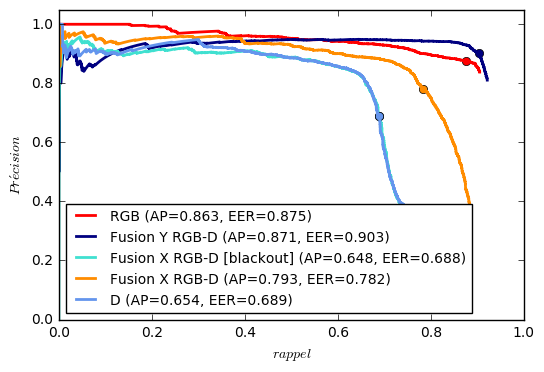

In [12]:
# Plot Precision-Recall curve for each class
plt.clf()
i=0

# x = np.linspace(0, 1, num=100, endpoint=True)
# y = np.linspace(0, 1, num=100, endpoint=True)
# plt.plot(x, y,  color='blue',marker='.') 


# todraw = ['oneraroom_easy_rgb','oneraroom_easy_depth_8bits','inout_x_on_oneraroom_easy_rgbd_10000','inout_y_on_oneraroom_easy_rgbd_100000','x_blackout']
for key in myList:
    if len(myList[key]['results']['person']['rec'])==0:
        continue
#     print key, np.mean(myList[key]['results']['person']['rec'])
    idx = np.argwhere(np.diff(np.sign(myList[key]['results']['person']['rec'] - myList[key]['results']['person']['prec'])) != 0).reshape(-1) + 0
    EER = myList[key]['results']['person']['rec'][idx]
    max_id_EER=np.argmax(EER)
    idx=idx[max_id_EER]
    EER = myList[key]['results']['person']['rec'][idx]
    plt.plot(myList[key]['results']['person']['rec'][idx], myList[key]['results']['person']['prec'][idx],  color=colors[i%len(colors)],marker='o')
    
    

#     print EER
    
    
    plt.plot(myList[key]['results']['person']['rec'], myList[key]['results']['person']['prec'], color=colors[i%len(colors)], lw=lw,
         label=myList[key]['name']+' (AP={:.3f}, EER={:.3f})'.format(myList[key]['results']['person']['ap'],EER))
        
    i+=1
#     +'(AP = {1:0.2f})'.format(myList[key]['results']['person']['ap'])

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('$rappel$')
plt.ylabel(r'$Pr\acute{e}cision$')

   
    
# plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower left",prop={'size':10})

# plt.plot([0.5], [0.8], color='color',marker='o')


plt.show()

In [11]:
idx

array([   0, 2943, 2944])

~~reconstruire les fonctions pour avoir une liste pour chaque image de :
~    TP TN FP FN precision recall mAP
    
ainsi on aura une liste par expert et une liste pour la fusion et on pourra trouver les images où la fusion s'avèrent utile. (notamment sur Inout pour expliquer le gain brut)

In [10]:
myList[key]['results']['person']['rec'][idx]

array([ 0.        ,  0.68828523,  0.68828523])

In [ ]:
for key in myList:
    if len(myList[key]['results']['person']['rec'])==0:
        continue
#     print key, np.mean(myList[key]['results']['person']['rec'])
    idx = np.argwhere(np.diff(np.sign(myList[key]['results']['person']['rec'] - myList[key]['results']['person']['prec'])) != 0).reshape(-1) + 0
    EER = myList[key]['results']['person']['rec'][idx]
    max_id_EER=np.argmax(EER)
    idx=idx[max_id_EER]
    EER = myList[key]['results']['person']['rec'][idx]




In [20]:
total_tp = sum(myList['oneraroom_easy_depth_8bits']['results']['person']['tp'])
total_fp = sum(myList['oneraroom_easy_depth_8bits']['results']['person']['fp'])

In [24]:
not0iou=[iou for iou in myList['oneraroom_easy_depth_8bits']['results']['person']['iou'] if iou!=0]


In [27]:
np.mean(not0iou)

0.68396699

In [21]:
myList['oneraroom_easy_depth_8bits']['results']['person']

{'ap': 0.65431064416079021,
 'fp': array([ 0.,  0.,  0., ...,  1.,  1.,  1.]),
 'iou': array([ 0.73708206,  0.62969398,  0.64560032, ...,  0.        ,
         0.        ,  0.        ], dtype=float32),
 'prec': array([ 1.        ,  1.        ,  1.        , ...,  0.37946506,
         0.37939959,  0.37933414]),
 'rec': array([  3.39558574e-04,   6.79117148e-04,   1.01867572e-03, ...,
          7.46689304e-01,   7.46689304e-01,   7.46689304e-01]),
 'tp': array([ 1.,  1.,  1., ...,  0.,  0.,  0.])}